# APLICACIÓN DEL MODELO ESN-VAE PARA LA DETECCIÓN DE ANOMALÍAS EN SEÑALES DE VIBRACIÓN

## Ejemplo de aplicación de la metodología propuesta en un caso real 

Adición de rutas de las librerías:

In [1]:
import sys
sys.path.append("../../Echo_State_Networks")
sys.path.append("../../Variational_Auto_Encoder")
sys.path.append("../")

Importación de módulos:

In [2]:
import matplotlib.pyplot as plt
import src.dataset_generator as dg #Genera series de tiempo (st) senoidales con y sin perturbación
import src.esn_features as esn_features #Rutinas de aprendizaje de st con ESNs
import src.vae_prob as vae_prob #Rutinas de entrenamiento y validación de VAE
from VAE.vae import VaeNetwork #Crea un VAE
from ESNs.standard import EsnNetwork #Crea una ESN
import tensorflow as tf
%matplotlib inline
sess = tf.InteractiveSession()

Generación de señales sin perturbación:

(10, 50000)

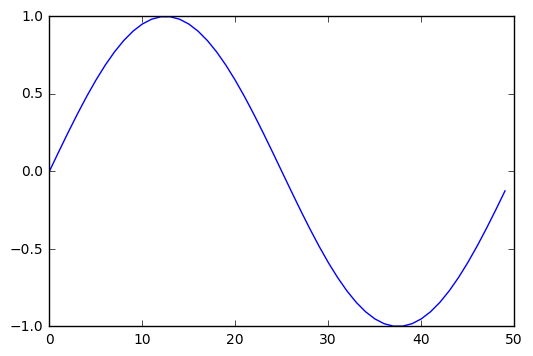

In [3]:
normal_signals = dg.sine_signals()
plt.plot(normal_signals[0,0:50])
normal_signals.shape

Generación de señales con perturbación:

(10, 50000)

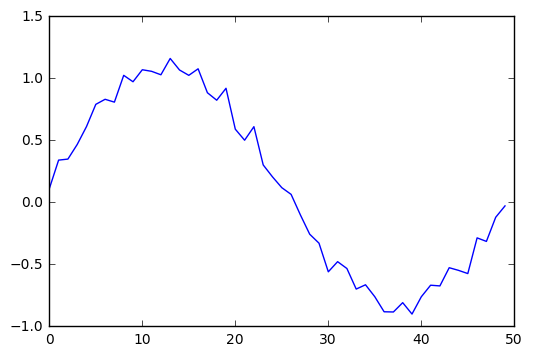

In [4]:
corrupted_signals = dg.corrupt_sine_signals()
plt.plot(corrupted_signals[0,0:50])
corrupted_signals.shape

Creación del reservorio:

In [5]:
prec = tf.float64
reservoir_size = 100
data = tf.placeholder(prec, [None, 1])
target = tf.placeholder(prec, [None, 1])
esn = EsnNetwork(data, target, reservoir_size=reservoir_size, prec=prec)

Creación de VAE:

In [6]:
network_architecture = dict(n_hidden_recog_1=1000,  # 1st layer encoder neurons
                            n_hidden_recog_2=1000,  # 2nd layer encoder neurons
                            n_hidden_gener_1=1000,  # 1st layer decoder neurons
                            n_hidden_gener_2=1000,  # 2nd layer decoder neurons
                            n_z=20)
features = tf.placeholder(tf.float32, [None, reservoir_size])
vae = VaeNetwork(features,network_architecture)
sess.run(tf.global_variables_initializer())

Extracción no-supervisada de características de la st sin perturbación con ESN:

In [7]:
batches = esn_features.feature_extraction(sess=sess, esn=esn, data=data, 
                                          target=target,
                                          signals=normal_signals,
                                          size_subsignals=1000,
                                          overlapping=100,delay=1)

Modelado de distribución de probabilidad por VAE:

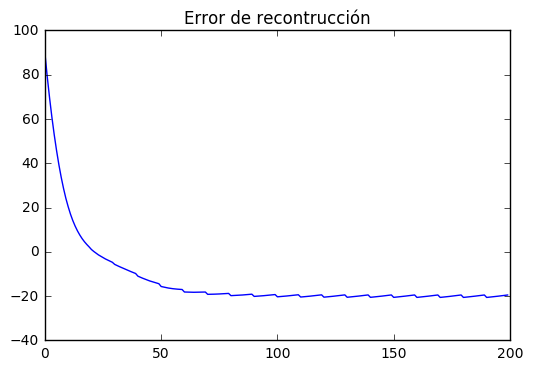

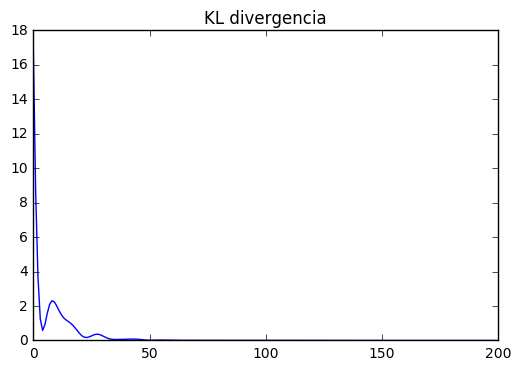

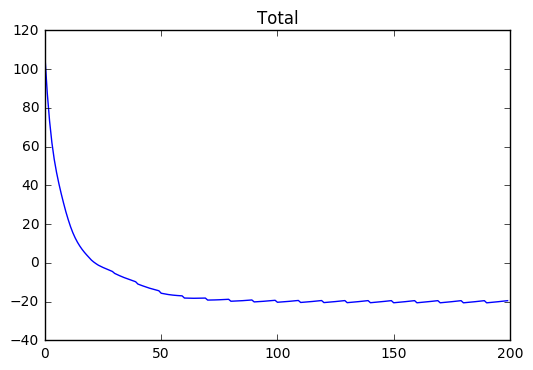

In [8]:
cost, vae = vae_prob.modelling_vae(sess=sess,vae=vae,data=features,batches=batches,epochs=20)
l_rec, l_l, l_total = [],[],[]
for epoch in cost:
    for Rec, L, Total in epoch:
        l_rec.append(Rec)
        l_l.append(L)
        l_total.append(Total)
plt.figure()
plt.plot(l_rec)
plt.title('Error de recontrucción')
plt.figure()
plt.plot(l_l)
plt.title('KL divergencia')
plt.figure()
plt.plot(l_total)
plt.title('Total')

Extracción no-supervisada de características de la st con perturbación con ESN:

In [9]:
corrupted_batches = esn_features.feature_extraction(sess=sess, esn=esn, data=data, 
                                          target=target,
                                          signals=corrupted_signals,
                                          size_subsignals=1000,
                                          overlapping=100,delay=1)

Representación de instancias en el plano de Erec y KL:

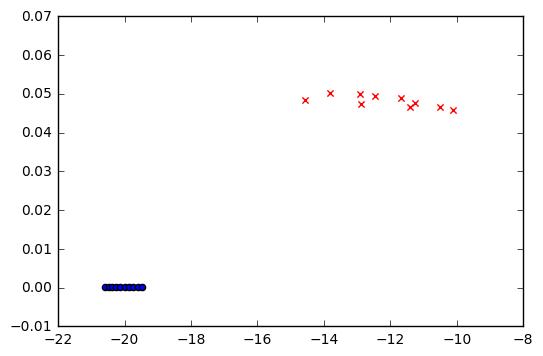

In [10]:
test_cost = vae_prob.test_esn_vae(sess=sess,vae=vae,data=features,
                                  batches=corrupted_batches)
test1,test2,test3 = zip(*test_cost)
plt.scatter(test1,test2,marker='x',color='r')
test_cost = vae_prob.test_esn_vae(sess=sess,vae=vae,data=features,
                                  batches=batches)
test1,test2,test3 = zip(*test_cost)
plt.scatter(test1,test2)